In [1]:
# necessary imports
import sqlalchemy as sqlconn
import pandas as pd
import numpy as np
from SQLConfig import config
import random
import pickle

import plotly.express as px
import plotly.graph_objs as go

from imblearn.over_sampling import SMOTE
from collections import Counter
from tqdm import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

import optuna as opt
from optuna.integration import XGBoostPruningCallback

from pdpbox import pdp
import shap

In [2]:
#PostgresSQL configuration
param=config()
url = f"postgresql+psycopg2://{param['user']}:{param['password']}@{param['host']}:{param['port']}/{param['database']}"
engine = sqlconn.create_engine(url)

In [3]:
def get_query(query:str):
    """Executes and SQL query and returns the results in dataframe format 

    Args:
        query (string): The SQL query to execute

    Returns:
        pandas dataframe: result of the SQL query
    """
    with engine.connect().execution_options(autocommit=True) as conn:
        df=pd.read_sql(sqlconn.text(query),conn)
        return df

In [4]:
def set_query(query:str):
    """Used to execute SQL queries that does not return any result such as INSERT,
       DELETE, CREATE commands

    Args:
        query (string): THE SQL query to execute
    """
    with engine.connect().execution_options(autocommit=True) as conn:
        conn.execute(sqlconn.text(query))

### Exploratory Data Analysis

In [5]:
#Top 5 records of customers data
# A lot of NULL values
sql="""
    SELECT *
    FROM customers
    LIMIT 5
"""
get_query(sql)

,customer_id,first,last,dob
0,0,None,Joseph,None
1,1,None,Vo,None
2,5,None,Brown,None
3,6,None,Bryant,None
4,7,None,Whitcher,None


In [6]:
#number of records in customers data
sql="""
    SELECT COUNT(*)
    FROM customers
"""
get_query(sql)

,count
0,9288


In [7]:
#number of rows having NULL value
sql="""
    SELECT COUNT(*)
    FROM customers
    WHERE first IS NULL or last IS NULL or dob IS NULL
"""
get_query(sql)

,count
0,8080


In [8]:
#top 5 records of receipts table
sql="""
    SELECT *
    FROM receipts
    LIMIT 5
"""
get_query(sql)

,receipt_id,purchased_at,customer_id,store_code,till_number
0,21841,2021-07-03,12879,0,2
1,119748,2021-12-17,15993,0,5
2,3496,2021-12-05,14721,2,9
3,99105,2021-01-18,5567,1,1
4,32321,2021-05-01,5718,1,4


In [9]:
#store activity per day
sql="""
    SELECT r.*,address
    FROM (
        SELECT purchased_at
            , store_code
            , COUNT(receipt_id) AS visits
        FROM receipts
        GROUP BY 1,2
        ) r
    LEFT JOIN stores USING(store_code)
"""
temp=get_query(sql)

In [10]:
#stores and their attributes
sql="""
    SELECT *
    FROM stores
"""
get_query(sql)

,store_code,address,postcode,lat,lng
0,0,"Sneinton Market, Nottingham",NG1 1DW,52.954056,-1.138721
1,1,"46c Frederick St, Birmingham",B1 3HN,52.485990,-1.912160
2,2,"300 Oxford St, London",W1C 1DX,51.514930,-0.144929
3,3,"95 Brick Ln, London",E1 6QL,51.521832,-0.071686


In [11]:
#scatter plot to compare store activity
fig=px.scatter(temp,x='purchased_at',y='visits',color='store_code')
fig.update_layout(
    width=1000,
    height=500,
    legend_title='Store_code'
)
fig.show()

In [12]:
#customer's purchase details on a given day
sql="""
    WITH customer_data AS (
            SELECT r.customer_id
                    , r.receipt_id
                    , purchased_at
                    , quantity
                    , value 
            FROM receipts r
            LEFT JOIN
            (   
                SELECT receipt_id, SUM(qty) quantity,SUM(value) value
                FROM receipt_lines
                GROUP BY 1
            ) t USING (receipt_id)
        ), 
        customer_all_data AS
            (
                SELECT customer_id
                    , purchased_at
                    , SUM(quantity) quantity
                    , SUM(value) value
                    , COUNT(receipt_id) visits
                FROM customer_data
                GROUP BY 1,2
                ORDER BY 1,2
            )
    SELECT *
    FROM customer_all_data
    LIMIT 10
"""
get_query(sql)

,customer_id,purchased_at,quantity,value,visits
0,0,2021-04-29,6.0,10.22,1
1,0,2021-10-11,21.0,29.06,2
2,0,2021-11-23,21.0,19.08,1
3,0,2021-12-28,14.0,19.19,1
4,0,2022-02-16,20.0,19.13,1
5,0,2022-03-13,10.0,10.29,1
6,0,2022-03-22,9.0,14.16,1
7,1,2020-12-19,10.0,12.85,1
8,1,2021-02-06,22.0,25.43,1
9,1,2021-04-08,8.0,15.84,1


In [13]:
#correlation between quantity and value
sql="""
    WITH customer_data AS (
            SELECT r.customer_id
                    , r.receipt_id
                    , purchased_at
                    , quantity
                    , value 
            FROM receipts r
            LEFT JOIN
            (   
                SELECT receipt_id, SUM(qty) quantity,SUM(value) value
                FROM receipt_lines
                GROUP BY 1
            ) t USING (receipt_id)
        ), 
        customer_all_data AS
            (
                SELECT customer_id
                    , purchased_at
                    , SUM(quantity) quantity
                    , SUM(value) value
                    , COUNT(receipt_id) visits
                FROM customer_data
                GROUP BY 1,2
                ORDER BY 1,2
            )
    SELECT CORR(quantity,value) correlation_qty_value
    FROM customer_all_data
    LIMIT 10
"""
get_query(sql)

,correlation_qty_value
0,0.000431


In [14]:
#Top 5 records of products table
sql="""
    SELECT *
    FROM products
    LIMIT 5
"""
get_query(sql)

,product_code,product_details,department_code,department_name,category_code,category_details,sub_category_code,sub_category_details
0,15003,BARRS IRN BRU EA,-2,RI Missing Departme,-2,RI Missing Secti,-2,RI Missing Sub_Secti
1,14432,ORKNEY BREWERY D,-2,RI Missing Departme,-2,RI Missing Secti,-2,RI Missing Sub_Secti
2,2545,HEB BREWING CO B,-2,RI Missing Departme,-2,RI Missing Secti,-2,RI Missing Sub_Secti
3,5822,SANGS ICE CREAM,-2,RI Missing Departme,-2,RI Missing Secti,-2,RI Missing Sub_Secti
4,17949,BEECHLANDS EGGS,-2,RI Missing Departme,-2,RI Missing Secti,-2,RI Missing Sub_Secti


In [15]:
#top 10 products sold by the company across all stores
sql="""
    WITH product_sales AS (
    SELECT product_code
          , SUM(qty) units_sold
    FROM receipt_lines
    GROUP BY 1
    )
    SELECT product_code
        , product_details
        , units_sold
    FROM product_sales
    LEFT JOIN products USING(product_code)
    ORDER BY 3 DESC
    LIMIT 10
"""
temp=get_query(sql)

In [16]:
#bar plot of top 10 most sold item across all stores
fig=px.bar(temp,x='product_details',y='units_sold')

fig.show()

In [17]:
#average day of a week and week of a month when customers shop
sql=f"""
    WITH active_data AS (
        SELECT purchased_at
            , extract(dow FROM purchased_at)  day_of_week
            , extract(day FROM purchased_at)  day_of_month
            , extract(month FROM purchased_at)  month_of_year
            , customer_id
            , store_code
        FROM receipts
    )
    SELECT month_of_year
        , AVG(day_of_week) avg_day_week
        , AVG(day_of_month) avg_day_month
    FROM active_data
    GROUP BY 1
"""
moy_avg=get_query(sql)

In [18]:
#plot of the day of a week and week of a month when customers shop
fig=go.Figure()
fig.add_traces(
    [
        go.Scatter(x=moy_avg.month_of_year,y=moy_avg.avg_day_week,mode='lines+markers',name='average_day_week_visit'),
        go.Scatter(x=moy_avg.month_of_year,y=moy_avg.avg_day_month,mode='lines+markers',name='average_day_month_visit')
    ]
)
fig.update_layout(
    width=1000,
    height=500,
    xaxis_title='month_of_year',
    yaxis_title='Day'
)
fig.show()

### Feature Engineering

In [ ]:
#DROP the table if it already exisits
sql_query=f"""
        DROP TABLE IF EXISTS engineered_ml_data
    """
set_query(sql_query)

In [ ]:
#Creating the non-temporal data (engineered_ml_data)
sql_query=f"""
        CREATE TABLE IF NOT EXISTS engineered_ml_data
        (
            customer_id INTEGER NOT NULL,
            purchased_day INTEGER NOT NULL,
            day_of_week INTEGER NOT NULL,
            day_of_month INTEGER NOT NULL,
            month_of_year INTEGER NOT NULL,
            visits INTEGER NOT NULL,
            quantity INTEGER NOT NULL,
            value FLOAT NOT NULL
        );
        
        WITH customer_data AS (
            SELECT r.customer_id
                    , r.receipt_id
                    , purchased_at
                    , quantity
                    , value 
            FROM receipts r
            LEFT JOIN
            (   
                SELECT receipt_id, SUM(qty) quantity,SUM(value) value
                FROM receipt_lines
                GROUP BY 1
            ) t USING (receipt_id)
        ), 
        customer_all_data AS
            (
                SELECT customer_id
                    , purchased_at
                    , SUM(quantity) quantity
                    , SUM(value) value
                    , COUNT(receipt_id) visits
                FROM customer_data
                GROUP BY 1,2
                ORDER BY 1,2
            ),
        customer_all_dates AS
            (
                SELECT DISTINCT customer_id
                    ,purchased_date::DATE purchased_at
                FROM receipts
                JOIN LATERAL generate_series('2020-07-22'::DATE,'2022-03-22'::DATE,'1 day'::INTERVAL) purchased_date ON TRUE
            ),
        customer_all_features AS
            (
                SELECT r.customer_id
                    , (r.purchased_at::DATE - '2020-07-22'::DATE)+1 purchased_day
                    , extract(dow FROM purchased_at)  day_of_week
                    , extract(day FROM purchased_at)  day_of_month
                    , extract(month FROM purchased_at)  month_of_year
                    , COALESCE(visits,0) visits
                    , COALESCE(quantity,0) quantity
                    , COALESCE(value,0) value
                FROM customer_all_dates r
                LEFT JOIN customer_all_data s USING (customer_id,purchased_at)
                ORDER BY 1,2
            )
        INSERT INTO engineered_ml_data
        SELECT *
        FROM customer_all_features
    """
#commit the created table
set_query(sql_query)

In [19]:
#Display the first 5 rows of engineered_ml_data
sql_sub_query="""
                SELECT *
                FROM engineered_ml_data
                LIMIT 5
        """
get_query(sql_sub_query)

,customer_id,purchased_day,day_of_week,day_of_month,month_of_year,visits,quantity,value
0,0,1,3,22,7,0,0,0.0
1,0,2,4,23,7,0,0,0.0
2,0,3,5,24,7,0,0,0.0
3,0,4,6,25,7,0,0,0.0
4,0,5,0,26,7,0,0,0.0


In [20]:
#Display the number of records in engineered_ml_data
sql_query=f"""
        SELECT COUNT(*)
        FROM engineered_ml_data
        LIMIT 5
"""
get_query(sql_query)

,count
0,5479173


In [21]:
#Calculate the total_visits on each day using engineered_ml_data
sql_query=f"""
        SELECT purchased_day
            , SUM(visits) total_visits
        FROM engineered_ml_data
        GROUP BY purchased_day
    """
#store the resultant dataframe as temp
temp=get_query(sql_query)

In [22]:
#purchased_day vs total_visits plot
#Using plotly, plot the purchase day on x-axis and total visits on y-axis 
fig=px.bar(temp,x='purchased_day',y='total_visits')
fig.update_traces(marker_color='blue')

#Draw a dotted horizontal line to indicate the the median number of visits in a day
fig.add_hline(np.median(temp.total_visits),line_dash="dash",line_color="red",annotation_text="Median visits", annotation_position="right",annotation_font_color='red')
fig.add_vrect(x0=0, x1=84,line_width=0, fillcolor="red", opacity=0.2)
fig.update_layout(
    width=1000,
    height=500
)
fig.show()

In [23]:
#DROP temporal_ml_data if it already exists
sql_query=f"""
        DROP TABLE IF EXISTS temporal_ml_data
"""
set_query(sql_query)

In [24]:
#Creating the temporal machine learning model input data using engineered_ml_data
#Define churn inactivity period
churn_def=39
#SQL query for the temporal_ml_data table
sql_query=f"""
        CREATE TABLE IF NOT EXISTS temporal_ml_data(
            customer_id INTEGER NOT NULL
            , ref_day INTEGER NOT NULL
            , day_of_week INTEGER NOT NULL
            , day_of_month INTEGER NOT NULL
            , month_of_year INTEGER NOT NULL
            , recent_purchased_day INTEGER NOT NULL
            , total_visits INTEGER NOT NULL
            , customer_age INTEGER NOT NULL
            , purchase_since_2m FLOAT NOT NULL
            , monetary_value FLOAT NOT NULL
            , churn INTEGER NOT NULL
        );
        
        WITH ml_data_engineered AS (
            SELECT *
            FROM
            (
                SELECT customer_id
                    , purchased_day ref_day
                    , day_of_week 
                    , day_of_month 
                    , month_of_year
                    , MAX(CASE WHEN value>0 THEN purchased_day ELSE 0 END) OVER (PARTITION BY customer_id ORDER BY purchased_day ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) recent_purchased_day
                    , SUM(visits) OVER (PARTITION BY customer_id ORDER BY purchased_day ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS total_visits
                    , MIN(CASE WHEN value>0 THEN purchased_day ELSE 'infinity'::FLOAT END) OVER (PARTITION BY customer_id ORDER BY purchased_day ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) min_purchased_day
                    
                    
                    , SUM(value) OVER (PARTITION BY customer_id ORDER BY purchased_day ROWS BETWEEN 59 PRECEDING AND CURRENT ROW) AS purchase_since_2m
                    , SUM(value) OVER (PARTITION BY customer_id ORDER BY purchased_day ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS total_purchase
                    , (CASE WHEN (SUM(value) OVER (PARTITION BY customer_id ORDER BY purchased_day ROWS BETWEEN {churn_def-8} PRECEDING AND 7 FOLLOWING))=0 THEN 1 ELSE 0 END) churn
                FROM engineered_ml_data
            ) r
            WHERE ref_day BETWEEN 60+85 AND 602
        ),
        ml_data_churn AS (
            SELECT customer_id
                , ref_day
                , day_of_week 
                , day_of_month 
                , month_of_year
                , recent_purchased_day
                , total_visits
                , (CASE WHEN min_purchased_day>0 THEN (CASE WHEN (ref_day-min_purchased_day)='-infinity'::FLOAT THEN 0 ELSE (ref_day-min_purchased_day)+1 END) ELSE 0 END) customer_age
                , purchase_since_2m
                , (CASE WHEN total_visits<>0 THEN ROUND((total_purchase/total_visits)::NUMERIC,2) ELSE 0 END) monetary_value
                , churn
            FROM ml_data_engineered
            ORDER BY customer_id, ref_day
        )
    INSERT INTO temporal_ml_data
    SELECT *
    FROM ml_data_churn
    """
#commit the created table
set_query(sql_query)

In [25]:
#Display the number of data points in temporal_ml_data table
sql_query=f"""
            SELECT COUNT(*)
            FROM temporal_ml_data
            LIMIT 5
    """
get_query(sql_query)

,count
0,4120626


In [26]:
#Display the first 5 data points of temporal_ml_data table
sql_query=f"""
            SELECT *
            FROM temporal_ml_data
            LIMIT 5
    """
get_query(sql_query)

,customer_id,ref_day,day_of_week,day_of_month,month_of_year,recent_purchased_day,total_visits,customer_age,purchase_since_2m,monetary_value,churn
0,0,145,0,13,12,0,0,0,0.0,0.0,1
1,0,146,1,14,12,0,0,0,0.0,0.0,1
2,0,147,2,15,12,0,0,0,0.0,0.0,1
3,0,148,3,16,12,0,0,0,0.0,0.0,1
4,0,149,4,17,12,0,0,0,0.0,0.0,1


In [27]:
#calculate the minimum and maximum days in the temporal_ml_data table
sql_sub_query="""
                SELECT MIN(ref_day),MAX(ref_day)
                FROM temporal_ml_data
                LIMIT 5
        """
get_query(sql_sub_query)

,min,max
0,145,602


In [28]:
#Check the number of data point where the recent_purchased_day, total_visits, customer_age, purchase_since_2m and monetary_value is 0
#These signify that that particular customer hasn't made their first purchase yet
sql_query=f"""
            SELECT COUNT(*)
            FROM temporal_ml_data
            WHERE (recent_purchased_day, total_visits, customer_age, purchase_since_2m, monetary_value)=(0,0,0,0,0) AND
            churn=1
    """
get_query(sql_query)

,count
0,814891


In [29]:
#DELETE all data points having recent_purchased_day, total_visits, customer_age, purchase_since_2m and monetary_value = 0
#since they are redundant and might skew the machine learning model
sql_query=f"""
            DELETE FROM temporal_ml_data
            WHERE (recent_purchased_day, total_visits, customer_age, purchase_since_2m, monetary_value)=(0,0,0,0,0) AND
            churn=1
    """
set_query(sql_query)

In [30]:
#check the number of data points in the refined temporal_ml_data table
sql_query=f"""
            SELECT COUNT(*)
            FROM temporal_ml_data
            LIMIT 5
    """
get_query(sql_query)

,count
0,3305735


In [31]:
#Churn vs active customers at the end of record
sql_sub_query="""
                SELECT SUM(CASE WHEN churn=0 THEN 1 ELSE 0 END) active_customers
                    , SUM(CASE WHEN churn=1 THEN 1 ELSE 0 END) churned_customers
                FROM temporal_ml_data
                where ref_day=602
        """
get_query(sql_sub_query)

,active_customers,churned_customers
0,2611,6386


In [32]:
sql_query=f"""
        SELECT *
        FROM temporal_ml_data
        WHERE ref_day=602
"""
temp=get_query(sql_query).loc[:,['recent_purchased_day', 'total_visits', 'customer_age','purchase_since_2m']]

In [33]:
corr_matrix=np.round(temp.corr(),2)
fig = px.imshow(corr_matrix, text_auto=True,aspect='auto')
fig.show()

### ML Model

In [34]:
#The minimum and maximum days available in the temporal_ml_data table
sql_query=f"""
        SELECT MIN(ref_day),MAX(ref_day)
        FROM temporal_ml_data
        """
get_query(sql_query)

,min,max
0,145,602


In [35]:
#instantiate a SMOTE object to over sample an input data with random state 42
sm=SMOTE(sampling_strategy='minority',random_state=42)

In [139]:
#validation decorator to check if the entered reference day is available in temporal_ml_data table
def temporal_decorator(func):
    """Decorator to validate input reference days

    Args:
        func (ref_days: integer, kwargs): a wrapper function for validation
    
    Returns:
        wrapper function
    """
    def wrapper(ref_days,**kwargs):
        """validaiton wrapper function

        Args:
            ref_days (integer): reference day

        Raises:
            ValueError: raised when the entered ref_day is out-of-bound of allowed ref_day
            TypeError: raised when incorrect data type of ref_day

        Returns:
            wrapped function
        """
        if isinstance(ref_days,int):
            if (ref_days<152 or ref_days>602) and kwargs.get('test'):
                raise ValueError("Reference day of validation set must be between 152 and 602")
            elif (ref_days<145 or ref_days>595) and not kwargs.get('test'):
                raise ValueError("Reference day of training set must be between 145 and 595")
        else:
            raise TypeError("Reference days must be an integer")
        
        return func(ref_days,kwargs)
    return wrapper

In [37]:
@temporal_decorator
def get_ml_temporal_X_y(ref_days,test=False,debug=False):
    """gets the input and output labels based on the ref_day
        input data is produced since last 100 days from ref_day
        also returns the active customer IDs on ref_day for a train data

    Args:
        ref_days (integer): _description_
        valid (bool, optional): whether to return validation data or not. Defaults to False.
        debug (bool, optional): displays the executed SQL query if set True. Defaults to False.

    Returns:
        Xy: input and output labels for valid data
        X: returns input and out labels seperately for training data 
        y: output labels of training data
        active_customer_ids: returns the active customer IDs on ref_day
    """    
    
    sql_query=f"""
        SELECT *
        FROM temporal_ml_data
        WHERE ref_day {f'={ref_days}' if test else f'BETWEEN {ref_days-99} AND {ref_days}'}
        """
    if debug:
        print(sql_query)
    
    Xy=get_query(sql_query)
    
    if test:
        return Xy
    
    #get active customer IDs for validation set so that prediction is done for active customers only
    active_customer_ids=Xy.customer_id.loc[(Xy.churn==0) & (Xy.ref_day==ref_days)]
    X=Xy.drop(columns=['customer_id','churn'])
    y=Xy.churn
    return X,y, active_customer_ids

In [38]:
def get_temporal_train_valid(train_ref_day:int):
    """builds a training and validation set based on training_ref_day

    Args:
        train_ref_day (int): training reference day

    Returns:
        X_train: input labels of training data
        y_train: output labels of training data
        X_valid: input labels of validation data
        y_valid: output labels of validation data
    """
    X_train,y_train,active_customer_ids=get_ml_temporal_X_y(train_ref_day)
    
    #SMOTE resampling of training data
    X_train,y_train=sm.fit_resample(X_train,y_train)
    
    #Build validation input and output labels    
    valid_data=get_ml_temporal_X_y(train_ref_day+7,valid=True)
    
    valid_data=valid_data.loc[valid_data.customer_id.isin(active_customer_ids)]
    X_valid,y_valid=valid_data.drop(columns=['customer_id','churn']),valid_data.churn
    
    return X_train,y_train,X_valid,y_valid
    

In [109]:
#create a training and validation set
X_train,y_train,X_valid,y_valid=get_temporal_train_valid(300)

#### Decision Tree

In [40]:
#instantiate a decision tree object
#baseline model
baseline=DecisionTreeClassifier(random_state=42)

In [41]:
#fit the model and predict output labels of validation set
baseline.fit(X_train,y_train)
dt_pred=baseline.predict(X_valid)

In [42]:
#calculate f1 score
f1_score(y_valid,dt_pred)

0.40892193308550184

In [43]:
#calculate balanced accuracy score
balanced_accuracy_score(y_valid,dt_pred)

0.6285046728971962

In [44]:
#calculate accuracy score
accuracy_score(y_valid,dt_pred)

0.9434968017057569

#### Random Forest Classifier

In [45]:
#instantitate a random forest classifier
rfc=RandomForestClassifier(random_state=42,n_jobs=2)

In [46]:
#fit the model and predict the output labels of validation set
rfc.fit(X_train,y_train)
rfc_pred=rfc.predict(X_valid)

In [47]:
#calculate f1 score
f1_score(y_valid,rfc_pred)

0.42066420664206644

In [48]:
#calculate balanced accuracy score
balanced_accuracy_score(y_valid,rfc_pred)

0.6331775700934579

In [49]:
#calculate accuracy score
accuracy_score(y_valid,rfc_pred)

0.9442075337597725

#### Extreme Gradient Boosting (XGBoost)

In [50]:
#balanced accuracy scorer for XGBoost
def balanced_accuracy_scorer(y_true,y_pred):
    """returns the 1 - balanced accuracy score that must be minimized by XGBoost

    Args:
        y_true (pandas.DataFrame,numpy.ndarray): true validation labels
        y_pred (pandas.DataFrame,numpy.ndarray): predicted validation labels

    Returns:
        float: 1-balanced_accuracy_score
    """
    y_pred=np.round(y_pred)
    return 1-balanced_accuracy_score(y_true,y_pred)

In [118]:
#f1 scorer for XGBoost
def f1_scorer(y_true,y_pred):
    """returns the 1 - f1 score score that must be minimized by XGBoost

    Args:
        y_true (pandas.DataFrame,numpy.ndarray): true validation labels
        y_pred (pandas.DataFrame,numpy.ndarray): predicted validation labels

    Returns:
        float: 1-f1_score
    """
    y_pred=np.round(y_pred)
    return 1-f1_score(y_true,y_pred)

In [122]:
#instantiate a XGBoost classifier
gbc=xgb.XGBClassifier(objective='binary:logistic',random_state=42,eval_metric=balanced_accuracy_scorer,early_stopping_rounds=50)

In [123]:
#fit the model and predict the labels of validation set
gbc.fit(X_train,y_train,eval_set=[(X_valid,y_valid)])
gbc_pred=gbc.predict(X_valid)

[0]	validation_0-logloss:0.50581	validation_0-balanced_accuracy_scorer:0.36682
[1]	validation_0-logloss:0.38317	validation_0-balanced_accuracy_scorer:0.36682
[2]	validation_0-logloss:0.30775	validation_0-balanced_accuracy_scorer:0.36682
[3]	validation_0-logloss:0.25930	validation_0-balanced_accuracy_scorer:0.36682
[4]	validation_0-logloss:0.23168	validation_0-balanced_accuracy_scorer:0.36682
[5]	validation_0-logloss:0.21804	validation_0-balanced_accuracy_scorer:0.36682
[6]	validation_0-logloss:0.21398	validation_0-balanced_accuracy_scorer:0.36682
[7]	validation_0-logloss:0.21672	validation_0-balanced_accuracy_scorer:0.36682
[8]	validation_0-logloss:0.22405	validation_0-balanced_accuracy_scorer:0.36682
[9]	validation_0-logloss:0.22769	validation_0-balanced_accuracy_scorer:0.50000
[10]	validation_0-logloss:0.23375	validation_0-balanced_accuracy_scorer:0.50000
[11]	validation_0-logloss:0.24746	validation_0-balanced_accuracy_scorer:0.50000
[12]	validation_0-logloss:0.26325	validation_0-bal

In [124]:
#return the balanced accuracy of the model
1-gbc.best_score

0.633178

In [125]:
#calculate prediction f1 score
f1_score(y_valid,gbc_pred)

0.42066420664206644

In [126]:
#calculate prediction accuracy
accuracy_score(y_valid,gbc_pred)

0.9442075337597725

### Hyper-parameter tuning (Dummy test)

In [127]:
#hyper-parameter tuning on one train and validation set
def objective_xgboost(trial,X_train,y_train,X_valid,y_valid):
    """an objective function for optuna to maximize the balanced accuracy

    Args:
        X_train: input labels of training data
        y_train: output labels of training data
        X_valid: input labels of validation data
        y_valid: output labels of validation data

    Returns:
        float: score of a trail
    """

    # -- XGBClassifier parameters
    param=dict(
        n_estimators=trial.suggest_int('n_estimators',2,1000),
        learning_rate=trial.suggest_float('learning_rate',0.01,0.5,step=0.01),
        max_depth=trial.suggest_int('max_depth',3,10),
        min_child_weight = trial.suggest_int('min_child_weight',1,6),
        gamma=trial.suggest_float('gamma',0,0.2,step=0.01),
        subsample=trial.suggest_float('subsample',0.5,0.9,step=0.01),
        colsample_bytree=trial.suggest_float('colsample_bytree',0.5,0.9,step=0.01),
        reg_lambda=trial.suggest_float('reg_lambda',0,0.1,step=0.001),
        scale_pos_weight=trial.suggest_int('scale_pos_weight',1,10)
        )          
    # -- fit model with pruning mechanism that stops early if the model does not do better than last trail.
    pruining_callback=XGBoostPruningCallback(trial, "validation_0-f1_scorer")
    model=xgb.XGBClassifier(objective='binary:logistic',**param,random_state=42,n_jobs=2,eval_metric=f1_scorer,callbacks=[pruining_callback],early_stopping_rounds=50,verbosity=0)
    
    # -- Fit model and evaluate score
    model.fit(X_train,y_train,eval_set=[(X_valid,y_valid)],verbose=0)
    score=1-model.best_score
    return score

In [128]:
#create a study of 100 trials
study=opt.create_study(study_name='xgboost optimization_pruned',direction="maximize", sampler=opt.samplers.TPESampler(seed=0), pruner=opt.pruners.HyperbandPruner())
#optimize XGBoost by maximizing the score
study.optimize(lambda trial: objective_xgboost(trial,X_train,y_train,X_valid,y_valid), n_trials=100,n_jobs=2)

[I 2023-05-11 05:23:41,843] A new study created in memory with name: xgboost optimization_pruned
[I 2023-05-11 05:23:50,552] Trial 0 finished with value: 0.42066400000000004 and parameters: {'n_estimators': 481, 'learning_rate': 0.09, 'max_depth': 5, 'min_child_weight': 6, 'gamma': 0.11, 'subsample': 0.79, 'colsample_bytree': 0.5700000000000001, 'reg_lambda': 0.015, 'scale_pos_weight': 9}. Best is trial 0 with value: 0.42066400000000004.
[I 2023-05-11 05:23:52,724] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 856, 'learning_rate': 0.13, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.01, 'subsample': 0.8300000000000001, 'colsample_bytree': 0.67, 'reg_lambda': 0.043000000000000003, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.42066400000000004.
[I 2023-05-11 05:24:02,967] Trial 3 finished with value: 0.18030500000000005 and parameters: {'n_estimators': 46, 'learning_rate': 0.16, 'max_depth': 9, 'min_child_weight': 2, 'gamma': 0.06, 'subsample': 0.67999999

In [111]:
#best parameters after hyper-parameter tuning
study.best_params

{'n_estimators': 784,
 'learning_rate': 0.4,
 'max_depth': 3,
 'min_child_weight': 5,
 'gamma': 0.09,
 'subsample': 0.62,
 'colsample_bytree': 0.64,
 'reg_lambda': 0.019,
 'scale_pos_weight': 4}

In [112]:
#Tuned XGBoost model with the optimized parameters
gbc_tuned=xgb.XGBClassifier(objective='binary:logistic',**study.best_params,random_state=42,eval_metric=balanced_accuracy_scorer,early_stopping_rounds=50,n_jobs=2)

In [113]:
#fit the model and evaluate on validaiton set
gbc_tuned.fit(X_train,y_train,eval_set=[(X_valid,y_valid)])

[0]	validation_0-logloss:0.61632	validation_0-balanced_accuracy_scorer:0.26466
[1]	validation_0-logloss:0.55997	validation_0-balanced_accuracy_scorer:0.24693
[2]	validation_0-logloss:0.58005	validation_0-balanced_accuracy_scorer:0.25140
[3]	validation_0-logloss:0.59342	validation_0-balanced_accuracy_scorer:0.24150
[4]	validation_0-logloss:0.44211	validation_0-balanced_accuracy_scorer:0.24162
[5]	validation_0-logloss:0.40914	validation_0-balanced_accuracy_scorer:0.24551
[6]	validation_0-logloss:0.38063	validation_0-balanced_accuracy_scorer:0.26072
[7]	validation_0-logloss:0.27038	validation_0-balanced_accuracy_scorer:0.35478
[8]	validation_0-logloss:0.27564	validation_0-balanced_accuracy_scorer:0.33533
[9]	validation_0-logloss:0.26600	validation_0-balanced_accuracy_scorer:0.33828
[10]	validation_0-logloss:0.21629	validation_0-balanced_accuracy_scorer:0.36682
[11]	validation_0-logloss:0.22209	validation_0-balanced_accuracy_scorer:0.36682
[12]	validation_0-logloss:0.21846	validation_0-bal

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.64, early_stopping_rounds=50,
              enable_categorical=False,
              eval_metric=<function balanced_accuracy_scorer at 0x13581d480>,
              feature_types=None, gamma=0.09, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.4, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, n_estimators=784, n_jobs=2,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [114]:
#predict validation output labels
y_pred=gbc_tuned.predict(X_valid)

#balanced accuracy of the model
print("Balanced accuracy:",1-gbc_tuned.best_score)

Balanced accuracy: 0.758503


In [115]:
#f1 score of validation set
f1_score(y_valid,y_pred)

0.28820269200316706

In [116]:
#accuracy on the validation set
accuracy_score(y_valid,y_pred)

0.6805259417199716

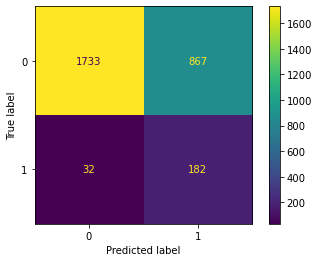

In [117]:
#plot confusion matrix of above model
cm = confusion_matrix(y_valid, y_pred, labels=gbc_tuned.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbc_tuned.classes_)
disp.plot()
plt.show()

### SHAP

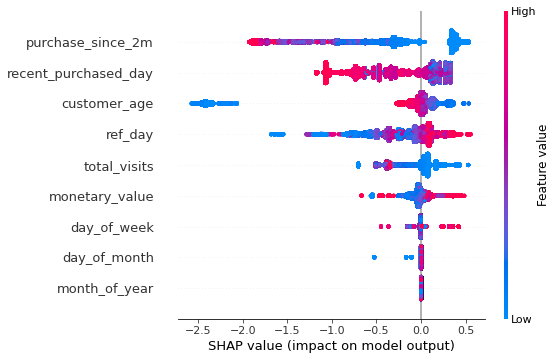

In [66]:
#SHAP plot of input features
shap_values = shap.TreeExplainer(gbc_tuned).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

### Cross-validation

In [67]:
#balanced accuracy scorer similar to "balanced_accuracy_scorer" function
def balanced_accuracy_cv(y_true,y_pred):
    """returns the 1 - balanced score that must be minimized by XGBoost

    Args:
        y_true (pandas.DataFrame,numpy.ndarray): true validation labels
        y_pred (pandas.DataFrame,numpy.ndarray): predicted validation labels

    Returns:
        float: 1-balanced_accuracy_score
    """
    y_pred=np.round(y_pred)
    return 1-balanced_accuracy_score(y_true,y_pred)

In [68]:
#optuna objective function similar to "objective_xgboost" function
def objective_xgboost_cv(trial,X_train,y_train,X_valid,y_valid):
    """an objective function for optuna to maximize the balanced accuracy

    Args:
        X_train: input labels of training data
        y_train: output labels of training data
        X_valid: input labels of validation data
        y_valid: output labels of validation data

    Returns:
        float: score of a trail
    """
    # -- XGBClassifier parameters
    param=dict(
        n_estimators=trial.suggest_int('n_estimators',2,1000),
        learning_rate=trial.suggest_float('learning_rate',0.01,0.5,step=0.01),
        max_depth=trial.suggest_int('max_depth',3,10),
        min_child_weight = trial.suggest_int('min_child_weight',1,6),
        gamma=trial.suggest_float('gamma',0,0.2,step=0.01),
        subsample=trial.suggest_float('subsample',0.5,0.9,step=0.01),
        colsample_bytree=trial.suggest_float('colsample_bytree',0.5,0.9,step=0.01),
        reg_alpha=trial.suggest_float('reg_alpha',0,0.1,step=0.001),
        scale_pos_weight=trial.suggest_int('scale_pos_weight',1,10)
        )          
    # -- Tune estimator algorithm
    pruining_callback=XGBoostPruningCallback(trial, "validation_0-balanced_accuracy_cv")
    model=xgb.XGBClassifier(objective='binary:logistic',**param,random_state=42,n_jobs=2,eval_metric=balanced_accuracy_cv,callbacks=[pruining_callback],early_stopping_rounds=50,verbosity=0)
    
    # -- Fit model
    model.fit(X_train,y_train,eval_set=[(X_valid,y_valid)],verbose=0)
    y_pred=model.predict(X_valid)
    score=1-model.best_score
    return score

In [69]:
#Cross-validation function that performs hyper-parmeter tuning for each cv and returns the scores and parameters
def xgboost_optimizer_cv(objective_f,cv=2,n_trials=100,n_jobs=1,all_params=False):
    """Cross-validation function that performs hyper-parmeter tuning for each cv 
        and returns the scores and parameters.

    Args:
        objective_f (object): optuna objective function
        cv (int, optional): number of cross-validations. Defaults to 2.
        n_trials (int, optional): number of trials for each hyper parameter tuning. Defaults to 100.
        n_jobs (int, optional): number of parallel processing. Defaults to 1.
        all_params (bool, optional): whether to return all parameter or only the best. Defaults to False.

    Returns:
        (list or int): scores of CV
        (list or dict): hyper-parameter of CV
    """
    cv_best_params = dict()
    cv_best_scores=[]
    train_ref_days=random.sample(range(145,595,108),cv)
    idx=0
    #choosen reference days at random
    print("CV reference days:",train_ref_days)
    
    #cross-validation
    for _ in tqdm(range(cv)):
        X_train,y_train,X_valid,y_valid=get_temporal_train_valid(train_ref_days[idx])
        
        study_pruned=opt.create_study(study_name=f'xgboost optimization_pruned_cv{cv}',direction="maximize", sampler=opt.samplers.TPESampler(seed=0), pruner=opt.pruners.HyperbandPruner())
        study_pruned.optimize(lambda trial:objective_f(trial,X_train,y_train,X_valid,y_valid), n_trials=n_trials,n_jobs=n_jobs)
        cv_best_params[idx]=study_pruned.best_params
        cv_best_scores.append(study_pruned.best_value)
        idx+=1
    
    if all_params:
        return cv_best_scores,cv_best_params
    
    return max(cv_best_scores),cv_best_params[cv_best_scores.index(max(cv_best_scores))]
    

In [70]:
#get scores and parameters of CV
score,param=xgboost_optimizer_cv(objective_xgboost_cv,cv=3,n_jobs=2,all_params=True)

CV reference days: [577, 469, 253]


  0%|          | 0/3 [00:00<?, ?it/s][I 2023-05-11 04:06:32,842] A new study created in memory with name: xgboost optimization_pruned_cv3
[I 2023-05-11 04:06:40,406] Trial 1 finished with value: 0.6989989999999999 and parameters: {'n_estimators': 620, 'learning_rate': 0.23, 'max_depth': 3, 'min_child_weight': 3, 'gamma': 0.16, 'subsample': 0.81, 'colsample_bytree': 0.62, 'reg_alpha': 0.098, 'scale_pos_weight': 4}. Best is trial 1 with value: 0.6989989999999999.
[I 2023-05-11 04:06:45,673] Trial 0 finished with value: 0.7253609999999999 and parameters: {'n_estimators': 108, 'learning_rate': 0.43, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.09, 'subsample': 0.63, 'colsample_bytree': 0.59, 'reg_alpha': 0.05, 'scale_pos_weight': 10}. Best is trial 0 with value: 0.7253609999999999.
[I 2023-05-11 04:06:49,090] Trial 2 finished with value: 0.716818 and parameters: {'n_estimators': 266, 'learning_rate': 0.43, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 0.19, 'subsample': 0.81, 'colsa

In [71]:
#scores of CV
print(score)

[0.729609, 0.7194769999999999, 0.779581]


In [73]:
best_param=param[score.index(max(score))]

### Feature Importance

In [74]:
X_train,y_train,X_valid,y_valid=get_temporal_train_valid(588)

In [75]:
#build a model with the best hyper-parameters
model=xgb.XGBClassifier(objective='binary:logistic',**best_param,random_state=42,n_jobs=2,eval_metric=balanced_accuracy_scorer,early_stopping_rounds=50,verbosity=0)

In [76]:
#fit the model with training data and evaluate on test data
model.fit(X_train,y_train,eval_set=[(X_valid,y_valid)],verbose=0)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.53, early_stopping_rounds=50,
              enable_categorical=False,
              eval_metric=<function balanced_accuracy_scorer at 0x13581d480>,
              feature_types=None, gamma=0.07, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.11, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, n_estimators=496, n_jobs=2,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [77]:
#balanced accuracy score
print("Balanced Accuracy:",1-model.best_score)

Balanced Accuracy: 0.706568


In [78]:
#predict test output labels and calculate f1 score
y_pred=model.predict(X_valid)
f1_score(y_valid,y_pred)

0.24980237154150198

In [79]:
#input features and their importance
x=dict(zip(gbc_tuned.feature_names_in_,gbc_tuned.feature_importances_))
x

{'ref_day': 0.10420488,
 'day_of_week': 0.001161826,
 'day_of_month': 0.015085582,
 'month_of_year': 0.15841492,
 'recent_purchased_day': 0.21173057,
 'total_visits': 0.11865993,
 'customer_age': 0.17149734,
 'purchase_since_2m': 0.20339264,
 'monetary_value': 0.015852356}

In [80]:
#plot the input feature importance
fig=px.bar(x=x.values(),y=x.keys(),orientation='h')
fig.update_layout(
    xaxis_title="Importance",
    yaxis_title="Features"
)
fig.show()

In [81]:
#choose feature with more than 0.1 importance.

### Final-model evaluation 

In [140]:
#function similar to "get_ml_temporal_X_y"
@temporal_decorator
def get_ml_temporal_X_y_test(ref_days,test=False,debug=False):
    """gets the input and output labels based on the ref_day
        input data is produced since day 1 till ref_day
        also returns the active customer IDs on ref_day for a train data
        also removes the unwanted features based on feature importance

    Args:
        ref_days (integer): _description_
        test (bool, optional): whether to return test data or not. Defaults to False.
        debug (bool, optional): displays the executed SQL query if set True. Defaults to False.

    Returns:
        Xy: input and output labels for valid data
        X: returns input and out labels seperately for training data 
        y: output labels of training data
        active_customer_ids: returns the active customer IDs on ref_day
    """
    sql_query=f"""
        SELECT *
        FROM temporal_ml_data
        WHERE ref_day {f'={ref_days}' if test else f'BETWEEN 145 AND {ref_days}'}
        """
    if debug:
        print(sql_query)
    
    Xy=get_query(sql_query)
    
    if test:
        return Xy
    
    active_customer_ids=Xy.customer_id.loc[(Xy.churn==0) & (Xy.ref_day==ref_days)]
    X=Xy.drop(columns=['customer_id','churn','day_of_week','day_of_month','monetary_value'])
    y=Xy.churn
    return X,y, active_customer_ids

In [141]:
def get_temporal_train_test_importanced(train_ref_day:int):
    """builds a training and test set based on training_ref_day

    Args:
        train_ref_day (int): training reference day

    Returns:
        X_train: input labels of training data
        y_train: output labels of training data
        X_valid: input labels of test data
        y_valid: output labels of test data
    """
    X_train,y_train,active_customer_ids=get_ml_temporal_X_y_test(train_ref_day)
    X_train,y_train=sm.fit_resample(X_train,y_train)
        
    valid_data=get_ml_temporal_X_y_test(train_ref_day+7,test=True)
    
    valid_data=valid_data.loc[valid_data.customer_id.isin(active_customer_ids)]
    X_valid,y_valid=valid_data.drop(columns=['customer_id','churn','day_of_week','day_of_month','monetary_value']),valid_data.churn
    
    return X_train,y_train,X_valid,y_valid
    

In [84]:
#balanced accuracy scorer similar to "balanced_accuracy_scorer" function
def balanced_accuracy_model(y_true,y_pred):
    """returns the 1 - balanced score that must be minimized by XGBoost

    Args:
        y_true (pandas.DataFrame,numpy.ndarray): true validation labels
        y_pred (pandas.DataFrame,numpy.ndarray): predicted validation labels

    Returns:
        float: 1-balanced_accuracy_score
    """
    y_pred=np.round(y_pred)
    return 1-balanced_accuracy_score(y_true,y_pred)

In [143]:
#final train and test set
X_train,y_train,X_test,y_test=get_temporal_train_test_importanced(595)

In [86]:
#build a model with the best hyper-parameters
model=xgb.XGBClassifier(objective='binary:logistic',**best_param,random_state=42,n_jobs=2,eval_metric=balanced_accuracy_model,early_stopping_rounds=50,verbosity=0)

In [87]:
#fit the model with training data and evaluate on test data
model.fit(X_train,y_train,eval_set=[(X_test,y_test)],verbose=0)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.53, early_stopping_rounds=50,
              enable_categorical=False,
              eval_metric=<function balanced_accuracy_model at 0x16c71b7f0>,
              feature_types=None, gamma=0.07, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.11, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, n_estimators=496, n_jobs=2,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [88]:
#balanced accuracy score
print("Balanced accuracy:",1-model.best_score)

Balanced accuracy: 0.7446999999999999


In [89]:
#predict test output labels and calculate f1 score
y_pred=model.predict(X_test)
f1_score(y_test,y_pred)

0.26338147833474934

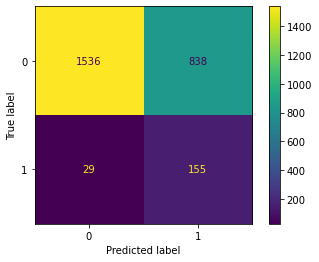

In [90]:
#plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [91]:
#classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.65      0.78      2374
           1       0.16      0.84      0.26       184

    accuracy                           0.66      2558
   macro avg       0.57      0.74      0.52      2558
weighted avg       0.92      0.66      0.74      2558



In [92]:
#churn rate
np.round(((len(y_test)-(len(y_pred)-np.count_nonzero(y_pred)))/len(y_test))*100,2)

38.82

### PDP and SHAP

In [ ]:
#PDP plot of 'purchase_since_2m'
pdp_obj = pdp.pdp_isolate(
    model=model, dataset=X_train, model_features=X_train.columns, feature='purchase_since_2m',num_grid_points = 100,n_jobs=2
)

fig, axes = pdp.pdp_plot(pdp_obj, 'purchase_since_2m', plot_lines=True, frac_to_plot=0.5, plot_pts_dist=True)

In [ ]:
#PDP plot of 'customer_age'
pdp_obj = pdp.pdp_isolate(
    model=model, dataset=X_train, model_features=X_train.columns, feature='customer_age',num_grid_points = 100,n_jobs=2
)

fig, axes = pdp.pdp_plot(pdp_obj, 'customer_age', plot_lines=True, frac_to_plot=0.5, plot_pts_dist=True)

In [ ]:
#SHAP plot of input features
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

### Train and save model

In [146]:
sql="""
    SELECT *
    FROM temporal_ml_data
"""
Xy=get_query(sql)
X_train=Xy.drop(columns=['customer_id','churn','day_of_week','day_of_month','monetary_value'])
y_train=Xy.churn
X_train,y_train=sm.fit_resample(X_train,y_train)

In [147]:
#build a model with the best hyper-parameters
final_model=xgb.XGBClassifier(objective='binary:logistic',**best_param,random_state=42,n_jobs=2,verbosity=0)
final_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.53, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.07, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.11, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=496, n_jobs=2, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [150]:
#export the trained model as pickle file
pickle.dump(final_model,open('churn_model.pkl','wb'))

### Pen Portraits

In [94]:
#get the customer_ids of active and churn customers at end day of dataset
sql="""
    SELECT customer_id
    FROM temporal_ml_data
    WHERE churn=1 AND ref_day=602
"""
churner_id=get_query(sql)
sql="""
    SELECT customer_id
    FROM temporal_ml_data
    WHERE churn=0 AND ref_day=602
"""
active_id=get_query(sql)

In [95]:
#first 5 rows of temporal_ml_data table
sql=f"""
    SELECT *
    FROM temporal_ml_data
    LIMIT 5
"""
get_query(sql)

,customer_id,ref_day,day_of_week,day_of_month,month_of_year,recent_purchased_day,total_visits,customer_age,purchase_since_2m,monetary_value,churn
0,0,275,4,22,4,0,0,0,0.0,0.0,0
1,0,276,5,23,4,0,0,0,0.0,0.0,0
2,0,277,6,24,4,0,0,0,0.0,0.0,0
3,0,278,0,25,4,0,0,0,0.0,0.0,0
4,0,279,1,26,4,0,0,0,0.0,0.0,0


In [96]:
#total average visits of churners and non-churners
sql=f"""
    SELECT ref_day
        , AVG(total_visits) FILTER (WHERE churn=1) AS avg_visits_of_churners
        , AVG(total_visits) FILTER (WHERE churn=0) AS avg_visits_of_actives
    FROM temporal_ml_data
    WHERE ref_day >300
    GROUP BY 1
"""
avg_visits=get_query(sql)

In [97]:
#plot a line graph of above query
fig=go.Figure()
fig.add_traces(
    [
        go.Scatter(x=avg_visits.ref_day,y=avg_visits.avg_visits_of_churners,mode='lines+markers',name='churners'),
        go.Scatter(x=avg_visits.ref_day,y=avg_visits.avg_visits_of_actives,mode='lines+markers',name='actives')
    ]
)
fig.update_layout(
    width=1000,
    height=500,
    xaxis_title='Ref_day',
    yaxis_title='Average_visits',
    title='Total Average number of visits'
)
fig.show()

In [98]:
#total average monetary value of churn and non-churn customers
sql=f"""
    SELECT ref_day
        , AVG(monetary_value) FILTER (WHERE churn=1) AS avg_mv_of_churners
        , AVG(monetary_value) FILTER (WHERE churn=0) AS avg_mv_of_actives
    FROM temporal_ml_data
    GROUP BY 1
"""
average_mv=get_query(sql)

In [99]:
#plot a line graph of above query
fig=go.Figure()
fig.add_traces(
    [
        go.Scatter(x=average_mv.ref_day,y=average_mv.avg_mv_of_churners,mode='lines+markers',name='churners'),
        go.Scatter(x=average_mv.ref_day,y=average_mv.avg_mv_of_actives,mode='lines+markers',name='actives')
    ]
)
fig.update_layout(
    width=1000,
    height=500,
    xaxis_title='Ref_day',
    yaxis_title='Average_monetary_value',
    title='Total Average monetary value'
)
fig.show()

In [100]:
#total average age of churn and non-churn customers
sql=f"""
    SELECT ref_day
        , AVG(customer_age) FILTER (WHERE churn=1) AS avg_age_of_churners
        , AVG(customer_age) FILTER (WHERE churn=0) AS avg_age_of_actives
    FROM temporal_ml_data
    GROUP BY 1
"""
average_age=get_query(sql)

In [101]:
#plot a line graph of above query
fig=go.Figure()
fig.add_traces(
    [
        go.Scatter(x=average_age.ref_day,y=average_age.avg_age_of_churners,mode='lines+markers',name='churners'),
        go.Scatter(x=average_age.ref_day,y=average_age.avg_age_of_actives,mode='lines+markers',name='actives')
    ]
)
fig.update_layout(
    width=1000,
    height=500,
    xaxis_title='Ref_day',
    yaxis_title='Average_customer_age'
)
fig.show()

In [102]:
#store activity of all churn customers
sql=f"""
    WITH active_data AS (
        SELECT purchased_at
            , customer_id
            , store_code
        FROM receipts
    )
    SELECT purchased_at
        , store_code
        , COUNT(customer_id) activity
    FROM active_data
    WHERE customer_id IN ({','.join(str(x) for x in churner_id.customer_id)})
    GROUP BY 1,2
"""
store_activity=get_query(sql)

In [103]:
#scatter plot of the activity
fig=px.scatter(store_activity,x='purchased_at',y='activity',color='store_code')
fig.show()

In [104]:
#store activity of all non-churn customers
sql=f"""
    WITH active_data AS (
        SELECT purchased_at
            , extract(dow FROM purchased_at)  day_of_week
            , extract(day FROM purchased_at)  day_of_month
            , extract(month FROM purchased_at)  month_of_year
            , customer_id
            , store_code
        FROM receipts
    )
    SELECT purchased_at
        , store_code
        , COUNT(customer_id) activity
    FROM active_data
    WHERE customer_id IN ({','.join(str(x) for x in active_id.customer_id)})
    GROUP BY 1,2
"""
store_activity=get_query(sql)

In [105]:
#scatter plot of non-churn customers
fig=px.scatter(store_activity,x='purchased_at',y='activity',color='store_code')
fig.show()

In [106]:
#top 10 products liked by non-churn customers
sql=f"""
    WITH product_data AS (
        SELECT customer_id
            , product_code
            , COUNT(product_code) qty
        FROM(
            SELECT customer_id
                , product_code
            FROM receipt_lines rl
            LEFT JOIN receipts USING (receipt_id)
        ) r
        GROUP BY 1,2
    ),
    product_qty AS (
        SELECT product_code
            , SUM(qty) qty
        FROM product_data
        WHERE customer_id IN ({ ','.join(str(x) for x in active_id.customer_id)})
        GROUP BY 1
        ORDER BY qty DESC
    )
    SELECT r.*
        , product_details
    FROM product_qty r
    LEFT JOIN products USING (product_code)
    LIMIT 10
"""
get_query(sql)

,product_code,qty,product_details
0,15738,10141.0,BANANAS LOOSE PE
1,12420,8955.0,HOME BRAND 4PINT FRES
2,11833,7336.0,HOME BRAND 2PINT FRES
3,19772,6486.0,CARROTS LOOSE PE
4,17120,4987.0,ONIONS LOOSE PER
5,10295,4746.0,NATIONAL LOTTO O
6,9985,4516.0,TOMATOES LOOSE P
7,8482,4210.0,PAY POINT EACH
8,9646,3965.0,HOME BRAND FRESH SEMI
9,2731,3562.0,HOME BRAND CLOSED CUP


In [107]:
#top 10 products liked by churn customers
sql=f"""
    WITH product_data AS (
        SELECT customer_id
            , product_code
            , COUNT(product_code) qty
        FROM(
            SELECT customer_id
                , product_code
            FROM receipt_lines rl
            LEFT JOIN receipts USING (receipt_id)
        ) r
        GROUP BY 1,2
    ),
    product_qty AS (
        SELECT product_code
            , SUM(qty) qty
        FROM product_data
        WHERE customer_id IN ({ ','.join(str(x) for x in churner_id.customer_id)})
        GROUP BY 1
        ORDER BY qty DESC
    )
    SELECT r.*
        , product_details
    FROM product_qty r
    LEFT JOIN products USING (product_code)
    LIMIT 10
"""
get_query(sql)

,product_code,qty,product_details
0,15738,2684.0,BANANAS LOOSE PE
1,11833,2174.0,HOME BRAND 2PINT FRES
2,19772,2081.0,CARROTS LOOSE PE
3,12420,1965.0,HOME BRAND 4PINT FRES
4,17120,1612.0,ONIONS LOOSE PER
5,10295,1550.0,NATIONAL LOTTO O
6,8482,1517.0,PAY POINT EACH
7,9985,1409.0,TOMATOES LOOSE P
8,9646,1257.0,HOME BRAND FRESH SEMI
9,14867,1228.0,SILVER SPOON GRA


In [151]:
print(x for x in range(5))

<generator object <genexpr> at 0x2e2f8d310>
